## Part 1: Load Libaries and Import necessary dataset

In [46]:
# Load required libraries. Make sure to install them too
library(readxl)
library(dplyr)
library(Rcpp)
library(ggplot2)
library(lubridate)
library(forecast)
library(prophet)
library(Metrics)
library(zoo) # use for date formatting 
library(stats) # use for additive


In [47]:

# Extract deposit_levels to use it in this file
deposit_levels <- readRDS("/workspaces/DUKE_MIDS_QFC_Final_Project/data_cleaning/deposit_levels.rds") # Load the data


## Part 2: Data Exploration for Prophet Assumption

In [48]:
glimpse(deposit_levels)

Rows: 162
Columns: 2
$ time     <chr> "1984Q1", "1984Q2", "1984Q3", "1984Q4", "1985Q1", "1985Q2", "…
$ deposits <dbl> 22917.26, 23575.19, 24308.97, 24967.96, 25673.75, 26941.33, 2…


### Step 1: Data Regularity and Sufficient Historical Data Expectation

- **Purpose**: Prophet requires data to be regular (no gaps in time periods) and free of missing values to build accurate forecasts.

In [49]:
sum(is.na(deposit_levels))  # no missing values

[1] 0

- The time series has regular quaterly intervals and no missing values so the data regurlarity expectation is satified. 

- It also has decades worth of data so the "sufficient historical data" expectation is satisfied. 

### Step 2: Presence of Trend Expectation

- **Purpose**: Prophet models require a clear understanding of the trend to accurately forecast future values. 

- **Next Steps**: Evaluate whether the data exhibits a linear or logistic trend.

- **Question** Does the choice of a linear trend or logistic trend affect Prophet's predictions?

- **Answer** : Yes, it absolutely affects the predictions. Here’s how:

    - **Linear Trend**: Assumes that growth continues indefinitely at a constant rate.
        - Future predictions will show a strong upward trend, even if the data is slowing down.
        - Example: If you fit a linear trend to deposit levels, Prophet will extrapolate a steadily increasing deposit level far into the future.

    - **Logistic Trend**: Assumes growth slows as it approaches a saturation point. 
        - Future predictions will show a more tamed upward trend, leveling off over time.
        - Example: If deposits are approaching a plateau, a logistic trend will reflect that in future predictions, ensuring the model doesn't over-predict growth.

- **Key Insight**:If you fit Prophet with the wrong trend type (e.g., linear when the data shows signs of saturation), your forecasts will misrepresent the future. Context is critical here: If you know from domain expertise or external analysis that growth will saturate, using a logistic trend will give more realistic predictions.

#### a. Formatting the time as a date instead of a character and also have anumeric format of the date

In [50]:
# Step 1: Format time as date 
# Format
time <- as.Date(as.yearqtr(deposit_levels$time, format = "%YQ%q"))
# Add the formatted date back into the dataset
deposit_levels$time_as_date <- time

# Step 2: Format time as numeric
# Format
time2 <- as.numeric(deposit_levels$time_as_date)
#  Add the formatted date back into the dataset
deposit_levels$time_as_numeric <- time2

# Check
glimpse(deposit_levels)



Rows: 162
Columns: 4
$ time            <chr> "1984Q1", "1984Q2", "1984Q3", "1984Q4", "1985Q1", "198…
$ deposits        <dbl> 22917.26, 23575.19, 24308.97, 24967.96, 25673.75, 2694…
$ time_as_date    <date> 1984-01-01, 1984-04-01, 1984-07-01, 1984-10-01, 1985-…
$ time_as_numeric <dbl> 5113, 5204, 5295, 5387, 5479, 5569, 5660, 5752, 5844, …


#### b. Visualizing Linear Trend

`geom_smooth()` using formula = 'y ~ x'


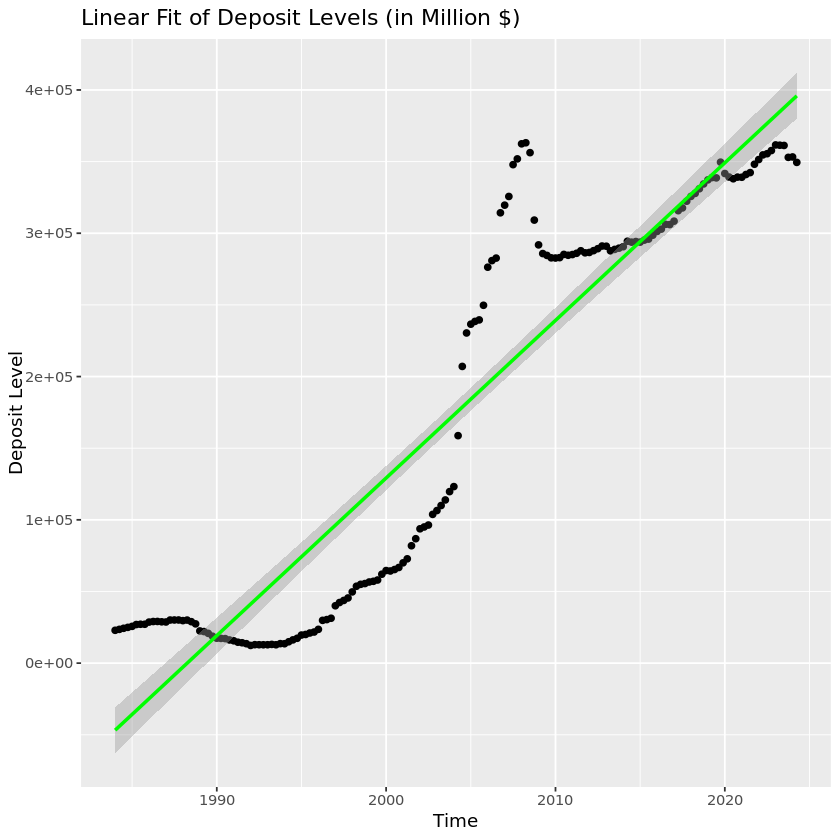

In [51]:
# Step 1: Time needs to be formatted as numeric for it to work ==> DONE above

# Step 2: Fit the linear model
linear_model <- lm(deposits ~ time_as_numeric ,data = deposit_levels) # Use time as numeric here

# Step 3: Plot the linear model
ggplot(deposit_levels, aes(x=time_as_date, y=deposits)) + # Use time as date here
    geom_point() +
    geom_smooth(method = lm, col = "green") + # Adds a linear trend
    labs(title = "Linear Fit of Deposit Levels (in Million $)", x = "Time", y = "Deposit Level")

#### c. Visualizing Logistic Growth Trend

- Not the same as logistic resgression

- A mathematical model used to describe non-linear growth that slows as it approaches a saturation point.

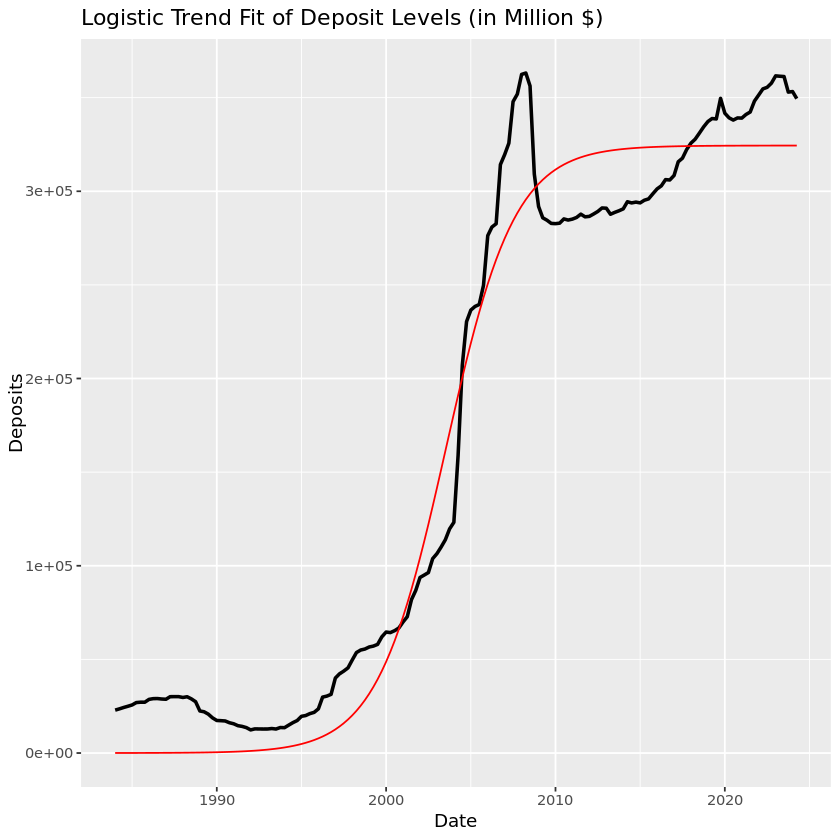

In [52]:
# Step 1: Define a logistic function
logistic_function <- function(x, L, k, x0) {
  L / (1 + exp(-k * (x - x0)))  # L = carrying capacity, k = growth rate, x0 = midpoint
}

# Step 2: Fit the logistic model
logistic_model <- nls(deposits ~ logistic_function(time_as_numeric, L, k, x0),
                      data = deposit_levels,
                      start = list(L = max(deposit_levels$deposits), k = 0.01, x0 = median(deposit_levels$time_as_numeric)))


# Step 3: Add logistic trend predictions to the dataset
deposit_levels <- deposit_levels %>%
  mutate(logistic_trend = predict(logistic_model))

# Step 4: Plot the linear model
ggplot(deposit_levels, aes(x = time_as_date, y = deposits)) +
  geom_line(color = "black", size = 1) +  # Actual data
  geom_line(aes(y = logistic_trend), color = "red") +  # Logistic trend
  labs(title = "Logistic Trend Fit of Deposit Levels (in Million $)", x = "Date", y = "Deposits") 

#### d. Conclusion for Trend

**What's likely to happen in the short term (2024-2028)**

==> Upward Growth Likely:

- Current high interest rate environment incentivizes deposits.
- Uncertainty about inflation and the economy may drive precautionary savings since we are recovering from the covid 19n crisis.
- Continued economic recovery post-pandemic suggests deposits will grow, though slower than during crisis periods.

**Which model do I pick**

==> Since we are predicting in the short term I will go with linear trend, 

**If we were forecasting long term (Beyond 2028)**

==> We would pick logistic trend

- Slower Growth or Plateau:
- As markets mature and financial penetration peaks, growth may slow.
- Deposits might grow proportionally with economic growth and population but at a decelerated rate


### Step 3: Seasonality

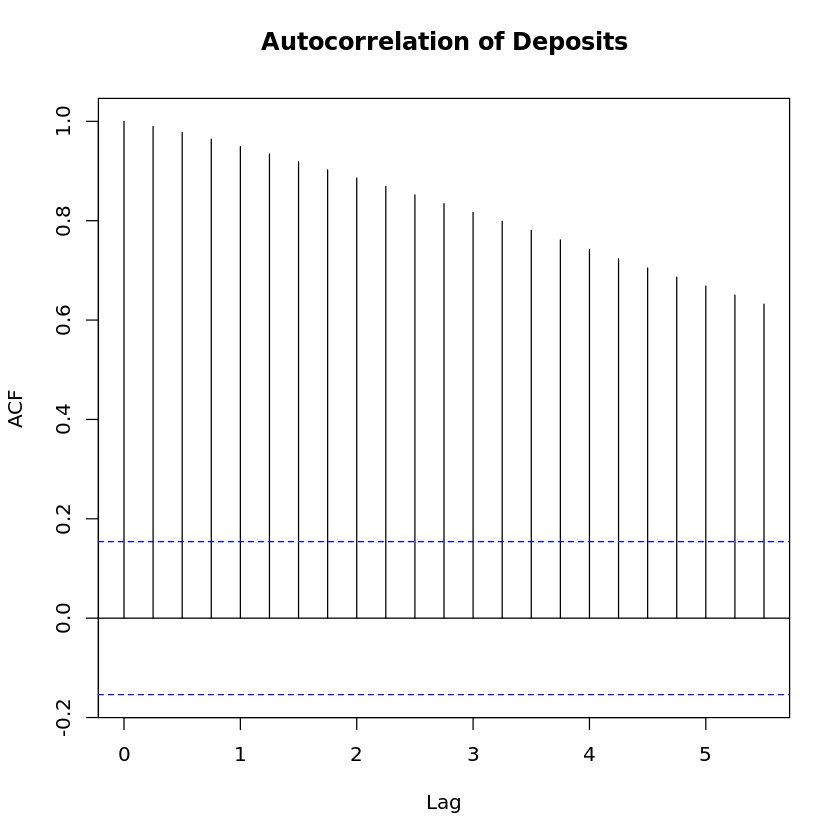

In [54]:
library(forecast)

# Plot ACF to check for seasonality
acf(ts_data, main = "Autocorrelation of Deposits")

# Look for significant spikes at lag = 4 (quarterly seasonality)


Decay pattern: Gradual decline: A slow decrease in correlation with increasing lags might indicate a trend in the data. 

Seasonal Patterns: Regularly spaced spikes at specific lags (multiples of a seasonal period) suggest seasonality in the time series. No Significant Spike at Lag 4 (Quarterly Seasonality). 
If the data had quarterly seasonality, there would be significant spikes at lag 4, lag 8, lag 12, etc.However, the absence of such spikes suggests that quarterly seasonality is weak or not present in this case.

Why no clear seasonality here?
The decomposition earlier showed a seasonal component, but the ACF does not strongly support it. This could mean:
- Dominant Trend:
The trend component (logistic growth) might be overwhelming the seasonal component, making it less apparent in the ACF.

- Weak Seasonality:
The seasonal pattern might exist but is too subtle to create significant autocorrelation spikes.

- Possible Data Noise:
Noise or external factors might be dampening the seasonal signal in the ACF

What I can do next to double check seasonality:
- Detrend the Data (Remove the Trend Component):
Since the trend dominates, remove it to isolate the seasonality. You can do this by subtracting the trend from the original data.


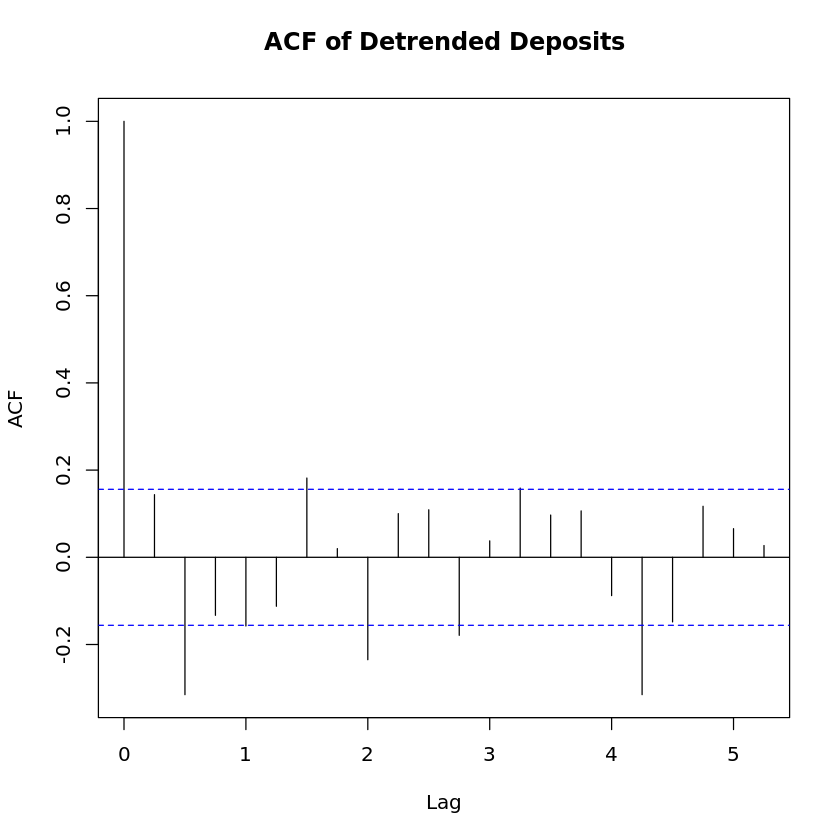

In [55]:
# Subtract the trend component, removing NA values
detrended_data <- ts_data - decomposition$trend

# Remove NA values from detrended data
detrended_data <- na.omit(detrended_data)

# Plot ACF of detrended data
acf(detrended_data, main = "ACF of Detrended Deposits")


- Based on the ACF of Detrended Deposits that you've shared, the absence of strong periodic spikes (like those at lag 4 for quarterly seasonality, lag 12 for monthly seasonality, or lag 2 for semi-annual seasonality) suggests that no other significant regular seasonality (monthly, semi-annual, etc.) is clearly present in your data.

- For now, proceed with a logistic growth model (like Prophet with growth = "logistic") and let Prophet's built-in seasonal detection handle any weak seasonal patterns

### Step 4: Outliers

In [56]:
# Calculate IQR
q1 <- quantile(deposit_levels$deposits, 0.25)
q3 <- quantile(deposit_levels$deposits, 0.75)
iqr <- q3 - q1

# Define lower and upper bounds
lower_bound <- q1 - 1.5 * iqr
upper_bound <- q3 + 1.5 * iqr

# Flag outliers
outliers <- deposit_levels %>%
  filter(deposits < lower_bound | deposits > upper_bound)

# Print outliers
print(outliers)


[1] time            deposits        time_as_date    time_as_numeric
[5] logistic_trend 
<0 rows> (or 0-length row.names)


Based of the results, it looks like the IQR method did not flag any outliers in the data. The deposit levels in the dataset fall within the acceptable range defined by the IQR method. The deposit levels may be naturally smooth without extreme spikes or dips (maybe lol?)

### Step 5: Noise

Prophet is robust to noise, but excessive noise may require preprocessing (e.g., smoothing).

In [57]:
# Calculate the variance of the residuals to quantify the noise and Compare this variance to the overall variance in the observed data.

# Variance of residuals (randomness)
residual_variance <- var(decomposition$random, na.rm = TRUE)

# Variance of the original data
observed_variance <- var(ts_data, na.rm = TRUE)

# Proportion of variance due to noise
noise_proportion <- residual_variance / observed_variance
noise_proportion


[1] 0.0006678225

- A higher proportion (close to 1) indicates the data is dominated by noise.
- A lower proportion (closer to 0) means the data has more structured patterns (e.g., trend, seasonality).

==>  Our noise proportion of approximately 0.00067 (a very small number), which means: noise contributes very little to the overall variability in your data. So there won't be any need for excessive smoothing or denoising steps. Prophet can effectively handle the low-level noise.

But for the decomposition of additive time series we clearly see randomness in our data even tho noise proportion is closer to 0. How do I include that in my prophet model to reflect the truth?

- Prophet will automatically detects changepoints in the trend. However, you can manually specify changepoints (e.g., around 2008) where the data exhibits high variability.


## Part 3: Model Evaluation: Train and Test

### Step 1: Split data between training and test data

In [58]:
train <- deposit_levels[deposit_levels$ds <= "2020-12-31", ]  # Training data: 1984 Q1 to 2020 Q4
test <- deposit_levels[deposit_levels$ds > "2020-12-31" & deposit_levels$ds <= "2024-06-30", ]  # Testing data: 2021 Q1 to 2024 Q2
#glimpse(train)
#glimpse(test)

### Step 2: Model Configurations Stage

### Step 3: Fit Prophet on training data

In [59]:
m <- prophet()
m <- fit.prophet(m, train)

ERROR: Error in fit.prophet(m, train): Dataframe must have columns 'ds' and 'y' with the dates and values respectively.


In [ ]:

# Step 3: Create future dataframe for both testing and prediction periods
future <- make_future_dataframe(m, periods = 28, freq = "quarter")  # 2021 Q1 to 2028 Q1

# Step 4: Generate forecast
forecast <- predict(m, future)

# Step 5: Evaluate RMSE for testing period
forecast_test <- forecast[forecast$ds > "2020-12-31" & forecast$ds <= "2024-06-30", ]  # Testing period
rmse_value <- rmse(test$deposits, forecast_test$yhat)
print(paste("RMSE for Testing Period:", rmse_value))

# Step 6: Visualize actual vs predicted and future forecast
ggplot() +
  geom_line(data = train, aes(x = ds, y = deposits), color = "black") +  # Training actuals
  geom_line(data = test, aes(x = ds, y = deposits), color = "blue", linetype = "dashed") +  # Testing actuals
  geom_line(data = forecast, aes(x = ds, y = yhat), color = "red") +  # Predictions (testing + future)
  labs(title = "Actual vs Predicted Deposits (Including Future Forecast)",
       x = "Date", y = "Deposits") +
  theme_minimal()

# Step 7: Display future forecast (2024 Q3 to 2028 Q1)
forecast_future <- forecast[forecast$ds > "2024-06-30", ]  # Future prediction period
print(forecast_future[, c("ds", "yhat", "yhat_lower", "yhat_upper")])


ERROR: Error in fit.prophet(m, train): Dataframe must have columns 'ds' and 'y' with the dates and values respectively.
